# Weather Correlation EDA

Using a new set of cleaned interim data provided by Satya, and looking for weather correlations such as ambient temperature.

The main question we're trying to answer is whether there's a correlation between weather data and FD service calls. 

First we'll look at some simple correlations, just to see if there's a relationship in general between temperature and # of calls. The null hypothesis is that there is no relationship.


After we try to explore this, we'll look at other ways we can explore these variables, such as rate of change:

The alt hypothesis is that the quantity of FD service calls significantly increases after the temperature becomes an outlier (hot or cold) for that time of day for that day of week, compared to prior time of days and days of week.

The null is that there is no significant correlation between temperature outliers and service calls.



In [338]:
from __future__ import division, print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [21]:
# we'll use the fresh download of the fire call csv, and do a little exploration
cols_to_use = ['Incident.Date',
               'Call.Number',
               'Zipcode',
               'Alarm.DtTm',
               'Location',
               'Incident.Number',
               'Close.DtTm',
               'Action.Taken.Primary',
               'type',
               'Address',
               'Neighborhood..District'
                ]
fdf = pd.read_csv('../../data/interim/Clean_Fire_Incidents.csv', usecols=cols_to_use)

In [26]:
# rename the columns so that it's easier to use built-in dot notation functions
fdf = fdf.rename(columns={'Incident.Number':'incident_number',
'Incident.Date':'incident_date',
'Call.Number':'call_number',
'Zipcode':'zipcode',
'Alarm.DtTm':'alarm_dttm',
'Location':'location',
'Close.DtTm':'close_dttm',
'Action.Taken.Primary':'action_taken_primary',
'type':'call_type',
'Address':'address',
'Neighborhood..District':'neighborhood_district'})

In [29]:
fdf.incident_date = pd.to_datetime(fdf.incident_date)

In [30]:
fdf.head()

,incident_number,address,incident_date,call_number,alarm_dttm,close_dttm,zipcode,action_taken_primary,neighborhood_district,location,call_type
0,3000001,1301 Turk St.,2003-07-08,31890183,2003-07-08 06:58:18,2003-07-08 06:58:39,94109,11 - extinguish,Tenderloin,"(37.7866410000297, -122.419321)",Building Fire
1,3000181,1251 Eddy St.,2003-01-01,30010241,2003-01-01 07:36:08,2003-01-01 07:44:07,0,86 - investigate,NaN,NaN,Building Fire
2,3000185,33 White St.,2003-01-01,30010246,2003-01-01 07:56:47,2003-01-01 08:02:53,94109,86 - investigate,Russian Hill,"(37.7976446500297, -122.41971707)",Building Fire
3,3000224,1201 12th Av.,2003-01-01,30010313,2003-01-01 11:31:21,2003-01-01 11:39:35,94122,86 - investigate,Inner Sunset,"(37.7657010000297, -122.469938)",Building Fire
4,3000232,832 Mission St.,2003-01-01,30010326,2003-01-01 12:33:52,2003-01-01 12:39:03,94103,86 - investigate,South of Market,"(37.7840465400297, -122.40539981)",Building Fire


In [31]:
fdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64330 entries, 0 to 64329
Data columns (total 11 columns):
incident_number          64330 non-null int64
address                  64324 non-null object
incident_date            64330 non-null datetime64[ns]
call_number              64330 non-null int64
alarm_dttm               64330 non-null datetime64[ns]
close_dttm               64330 non-null datetime64[ns]
zipcode                  64330 non-null int64
action_taken_primary     64330 non-null object
neighborhood_district    54526 non-null object
location                 55798 non-null object
call_type                64330 non-null object
dtypes: datetime64[ns](3), int64(3), object(5)
memory usage: 5.9+ MB


In [23]:
# based on above we have some typing to do
for col in fdf.columns:
    if 'dttm' in col.lower():
        fdf[col] = pd.to_datetime(fdf[col])

In [33]:
fdf.loc[0]

incident_number                                  3000001
address                                    1301 Turk St.
incident_date                        2003-07-08 00:00:00
call_number                                     31890183
alarm_dttm                           2003-07-08 06:58:18
close_dttm                           2003-07-08 06:58:39
zipcode                                            94109
action_taken_primary                     11 - extinguish
neighborhood_district                         Tenderloin
location                 (37.7866410000297, -122.419321)
call_type                                  Building Fire
Name: 0, dtype: object

## Observations of the cleaned dataset

 * All call_type values are 'Building Fire' which is useful, but if one of the goals is to reduce the burden on the SFFD, false alarms should also be included.
 * It appears there are numerical values for `action_taken_primary` so those could be split and parsed and mapped to an index, making the field a simple int. Something to try
 * neighborhood district and some of the location values appear to be null, so that will probably need to be fixed at a later stage if we want to do localized temperature correlations

In [159]:
# we'll do the same thing with the weather csv, do a little exploration on it too
tdf = pd.read_table('../../data/external/noaa/5991787088242dat.txt', delim_whitespace=True)


In [160]:
# TODO: 4,21 have mixed dtypes, so that must be fixed. It looks like TEMP has **** instead of a NaN value


In [161]:
# we need to fix the YR--MODAHRMN column
# YR--MODAHRMN = YEAR-MONTH-DAY-HOUR-MINUTE IN GREENWICH MEAN TIME (GMT)
tdf['data_time'] = pd.to_datetime(tdf['YR--MODAHRMN'], format='%Y%m%d%H%M')

In [162]:
tdf['data_time'].min() # kind of a bummer that the entire dataset only goes back to 2013. Why did we do that?? 
# TODO: requery NOAA for records going back to 2000.

Timestamp('2013-02-01 00:00:00')

In [163]:
# since column 21 is TEMP and that is really important to us, we'll fix that one first
mask = tdf['TEMP'] == '****'
tdf.loc[mask, 'TEMP'] = np.nan

In [164]:
tdf.TEMP = pd.to_numeric(tdf.TEMP)

In [165]:
tdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156781 entries, 0 to 156780
Data columns (total 34 columns):
USAF            156781 non-null int64
WBAN            156781 non-null int64
YR--MODAHRMN    156781 non-null int64
DIR             156781 non-null object
SPD             156781 non-null object
GUS             156781 non-null object
CLG             156781 non-null object
SKC             156781 non-null object
L               156781 non-null object
M               156781 non-null object
H               156781 non-null object
VSB             156781 non-null object
MW              156781 non-null object
MW.1            156781 non-null object
MW.2            156781 non-null object
MW.3            156781 non-null object
AW              156781 non-null object
AW.1            156781 non-null object
AW.2            156781 non-null object
AW.3            156781 non-null object
W               156781 non-null object
TEMP            154481 non-null float64
DEWP            156781 non-null o

In [166]:
tdf.head()

,USAF,WBAN,YR--MODAHRMN,DIR,SPD,GUS,CLG,SKC,L,M,...,ALT,STP,MAX,MIN,PCP01,PCP06,PCP24,PCPXX,SD,data_time
0,724940,23234,201302010000,***,0,***,722,CLR,0,0,...,*****,1019.5,62,42,*****,*****,*****,*****,**,2013-02-01 00:00:00
1,724940,23234,201302010056,310,5,***,722,SCT,*,*,...,30.19,1021.7,***,***,0.00,*****,*****,*****,**,2013-02-01 00:56:00
2,724940,23234,201302010156,280,8,***,722,SCT,*,*,...,30.18,1021.4,***,***,0.00,*****,*****,*****,**,2013-02-01 01:56:00
3,724940,23234,201302010256,280,8,***,722,CLR,*,*,...,30.19,1021.7,***,***,0.00,*****,*****,*****,**,2013-02-01 02:56:00
4,724940,23234,201302010356,280,7,***,722,CLR,*,*,...,30.19,1021.7,***,***,0.00,*****,*****,*****,**,2013-02-01 03:56:00


In [167]:
# to make this a little easier to work with let's grab the station ids and limit our data points to only 1 station,
# perhaps the one with the fewest null values?
tdf.groupby('USAF').count()['TEMP']

USAF
724940    39236
992640    29455
994016    29311
998011    29822
998479    26657
Name: TEMP, dtype: int64

In [168]:
# 724940 is at SF International Airport, which is a little too far south for my taste. Let's see if we can get closer
# oh, it occurs to me that if the temp is absent, we should drop it from our dataset.
tdf = tdf[tdf.TEMP.notnull()]
tdf = tdf[tdf.USAF != 724940]

In [169]:
# the second most records comes from 998011 which is near Fairfield. We should get rid of those
tdf = tdf[tdf.USAF != 998011]

In [170]:
tdf.groupby('USAF').count()['TEMP'].sort_values(ascending=False)

USAF
992640    29455
994016    29311
998479    26657
Name: TEMP, dtype: int64

In [171]:
# 992640 is from 18 nautical miles off the coast of SF, so not useful, we'll nix that too
tdf = tdf[tdf.USAF != 992640]

In [172]:
# 994016 is in the water off of Fort Mason, so a little better, we'll hold onto that value
# 998479 is pier 1 near the ferry building
# This is disappointing because it means we don't have any reading from inland in the city
# we only have 2 station locations that are close enough to SF to give a good idea of what's going on
tdf.groupby('USAF').count()['TEMP'].sort_values(ascending=False)

USAF
994016    29311
998479    26657
Name: TEMP, dtype: int64

In [173]:
tdf.iloc[-1]

USAF                         998479
WBAN                          99999
YR--MODAHRMN           201607162100
DIR                             270
SPD                              11
GUS                             ***
CLG                             ***
SKC                             ***
L                                 *
M                                 *
H                                 *
VSB                            ****
MW                               **
MW.1                             **
MW.2                             **
MW.3                             **
AW                               **
AW.1                             **
AW.2                             **
AW.3                             **
W                                 *
TEMP                             63
DEWP                           ****
SLP                          ******
ALT                           *****
STP                          ******
MAX                             ***
MIN                         

In [174]:
tdf.iloc[-1].head()

USAF                  998479
WBAN                   99999
YR--MODAHRMN    201607162100
DIR                      270
SPD                       11
Name: 156780, dtype: object

In [175]:
tdf.iloc[0].head()

USAF                  994016
WBAN                   99999
YR--MODAHRMN    201302010000
DIR                      230
SPD                        5
Name: 70225, dtype: object

In [176]:
# of all the station locations, let's just start with the ferry building and see if there are correlations there
tdf.groupby('USAF').min()['data_time'].sort_values(ascending=False)

USAF
998479   2013-02-01
994016   2013-02-01
Name: data_time, dtype: datetime64[ns]

In [177]:
tdf.groupby('USAF').max()['data_time'].sort_values(ascending=False)

USAF
998479   2016-07-16 21:00:00
994016   2016-07-16 21:00:00
Name: data_time, dtype: datetime64[ns]

In [178]:
# since the min and max values are the same for both weather stations, I'll take the ferry building for now.
tdf = tdf[tdf.USAF == 998479]

In [179]:
tdf.shape

(26657, 34)

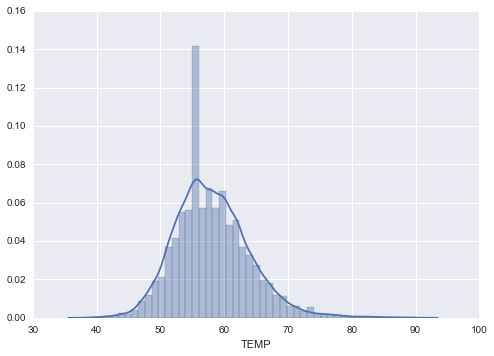

In [180]:
sns.distplot(tdf.TEMP);

In [181]:
tdf.describe()

,USAF,WBAN,YR--MODAHRMN,TEMP
count,26657,26657,2.665700e+04,26657.000000
mean,998479,99999,2.014327e+11,58.078178
std,0,0,9.979859e+07,5.942638
min,998479,99999,2.013020e+11,38.000000
25%,998479,99999,2.013113e+11,54.000000
50%,998479,99999,2.014092e+11,58.000000
75%,998479,99999,2.015072e+11,62.000000
max,998479,99999,2.016072e+11,91.000000


In [182]:
tdf.tail()

,USAF,WBAN,YR--MODAHRMN,DIR,SPD,GUS,CLG,SKC,L,M,...,ALT,STP,MAX,MIN,PCP01,PCP06,PCP24,PCPXX,SD,data_time
156776,998479,99999,201607161700,270,6,***,***,***,*,*,...,*****,******,***,***,*****,*****,*****,*****,**,2016-07-16 17:00:00
156777,998479,99999,201607161800,250,9,***,***,***,*,*,...,*****,******,***,***,*****,*****,*****,*****,**,2016-07-16 18:00:00
156778,998479,99999,201607161900,260,9,***,***,***,*,*,...,*****,******,***,***,*****,*****,*****,*****,**,2016-07-16 19:00:00
156779,998479,99999,201607162000,260,9,***,***,***,*,*,...,*****,******,***,***,*****,*****,*****,*****,**,2016-07-16 20:00:00
156780,998479,99999,201607162100,270,11,***,***,***,*,*,...,*****,******,***,***,*****,*****,*****,*****,**,2016-07-16 21:00:00


In [183]:
fdf.columns

Index([u'incident_number', u'address', u'incident_date', u'call_number',
       u'alarm_dttm', u'close_dttm', u'zipcode', u'action_taken_primary',
       u'neighborhood_district', u'location', u'call_type'],
      dtype='object')

In [291]:
# wnow let's try to map both dataframes together, and run groupby functions and correlations
# in the interest of time we'll just focus on the TEMP field and go from there

# We should probably make a mapping function to map the temperature for a call to the closest datetime value
# it appears the granularity of the data is by the hour.
# one simply way of dealing with this is to create a new dataframe, df,
# and the index is the datetime by the hour
# then do a groupby for number of incidents in that hour.
# so the item will have datetime, temperature, incident count
df = fdf.set_index('alarm_dttm').groupby(pd.TimeGrouper('H')).count()['incident_number']

In [292]:
df = df.reset_index()

In [293]:
df.head()

,alarm_dttm,incident_number
0,2003-01-01 07:00:00,2
1,2003-01-01 08:00:00,0
2,2003-01-01 09:00:00,0
3,2003-01-01 10:00:00,0
4,2003-01-01 11:00:00,1


In [294]:
df.min()

alarm_dttm         2003-01-01 07:00:00
incident_number                      0
dtype: object

In [295]:
# I realized that if I don't have temperature data for 2003, I need to drop that, so let's limit df to only those dates
# where we have a temp value
tdf.USAF.value_counts()

998479    26657
Name: USAF, dtype: int64

In [296]:
tdf.iloc[-1]

USAF                         998479
WBAN                          99999
YR--MODAHRMN           201607162100
DIR                             270
SPD                              11
GUS                             ***
CLG                             ***
SKC                             ***
L                                 *
M                                 *
H                                 *
VSB                            ****
MW                               **
MW.1                             **
MW.2                             **
MW.3                             **
AW                               **
AW.1                             **
AW.2                             **
AW.3                             **
W                                 *
TEMP                             63
DEWP                           ****
SLP                          ******
ALT                           *****
STP                          ******
MAX                             ***
MIN                         

In [297]:
temp_df = tdf[['data_time','TEMP']]
temp_df.head()

,data_time,TEMP
129795,2013-02-01 00:00:00,61
129796,2013-02-01 01:00:00,61
129797,2013-02-01 02:00:00,60
129798,2013-02-01 03:00:00,58
129799,2013-02-01 04:00:00,57


In [298]:
df = df.rename(columns={'alarm_dttm':'dttm'})

In [299]:
temp_df = temp_df.rename(columns={'data_time':'dttm'})

In [300]:
df = df.merge(temp_df)

In [301]:
df.head()

,dttm,incident_number,TEMP
0,2013-02-01 00:00:00,1,61
1,2013-02-01 01:00:00,0,61
2,2013-02-01 02:00:00,1,60
3,2013-02-01 03:00:00,1,58
4,2013-02-01 04:00:00,0,57


In [302]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26148 entries, 0 to 26147
Data columns (total 3 columns):
dttm               26148 non-null datetime64[ns]
incident_number    26148 non-null int64
TEMP               26148 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 817.1 KB


In [303]:
df = df.rename(columns={'incident_number':'incident_count'})

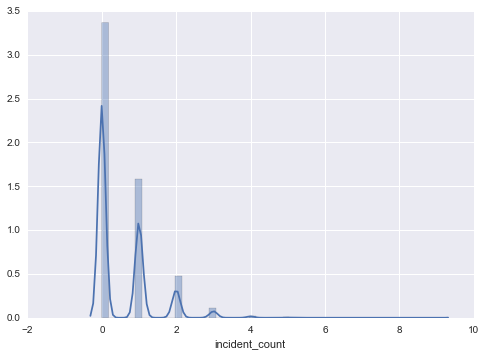

In [304]:
sns.distplot(df.incident_count)

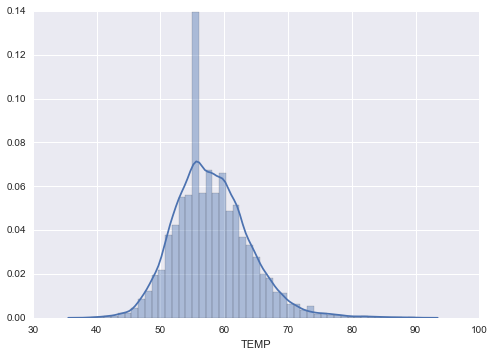

In [305]:
sns.distplot(df.TEMP)

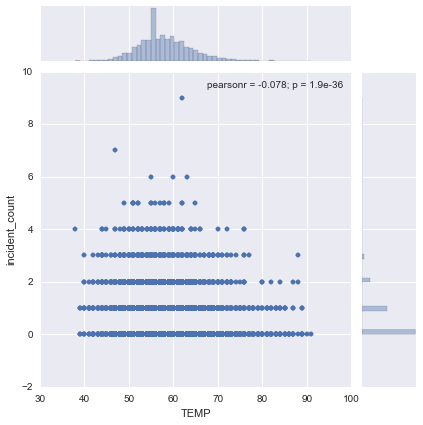

In [306]:
sns.jointplot(x="TEMP", y="incident_count", data=df);

In [307]:
df = df.set_index('dttm')

In [308]:
ndf = df.groupby(pd.TimeGrouper('D')).mean()

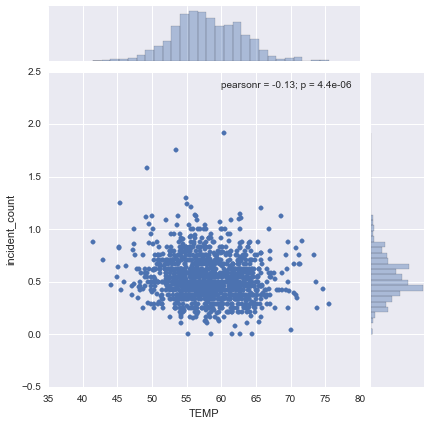

In [309]:
sns.jointplot(x="TEMP", y="incident_count", data=ndf);

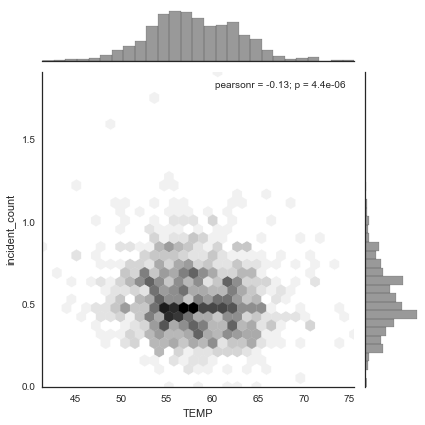

In [310]:

with sns.axes_style("white"):
    sns.jointplot(x="TEMP", y="incident_count", data=ndf, kind='hex', color='k');

In [311]:
# TODO: look only at when the incident count is high
# TODO: did it wrong! rebuild with 'D' seperately and merge
df = fdf.set_index('alarm_dttm').groupby(pd.TimeGrouper('D')).count()['incident_number']
df = df.reset_index()

In [312]:
temp_df = tdf[['data_time','TEMP']]
temp_df = temp_df.set_index('data_time').groupby(pd.TimeGrouper('d')).mean()['TEMP']
temp_df.head()

data_time
2013-02-01    54.083333
2013-02-02    52.750000
2013-02-03    51.083333
2013-02-04    49.916667
2013-02-05    49.541667
Freq: D, Name: TEMP, dtype: float64

In [313]:
temp_df = temp_df.reset_index().rename(columns={'data_time':'dttm'})


In [314]:
temp_df.head()

,dttm,TEMP
0,2013-02-01,54.083333
1,2013-02-02,52.750000
2,2013-02-03,51.083333
3,2013-02-04,49.916667
4,2013-02-05,49.541667


In [315]:
df.head()

,alarm_dttm,incident_number
0,2003-01-01,15
1,2003-01-02,12
2,2003-01-03,10
3,2003-01-04,14
4,2003-01-05,13


In [316]:
df = df.rename(columns={'incident_number':'incident_count'})

In [317]:
df = df.rename(columns={'alarm_dttm':'dttm'})


In [318]:
df = df.merge(temp_df)

In [319]:
df.head()

,dttm,incident_count,TEMP
0,2013-02-01,13,54.083333
1,2013-02-02,15,52.750000
2,2013-02-03,15,51.083333
3,2013-02-04,13,49.916667
4,2013-02-05,15,49.541667


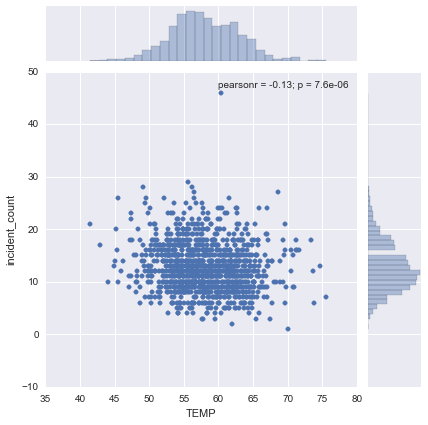

In [320]:
sns.jointplot(x="TEMP", y="incident_count", data=df);

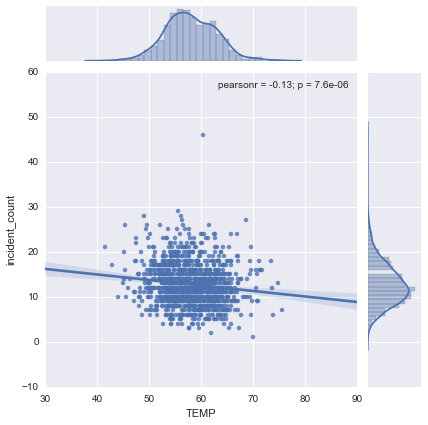

In [321]:
sns.jointplot(x="TEMP", y="incident_count", data=df, kind='reg');

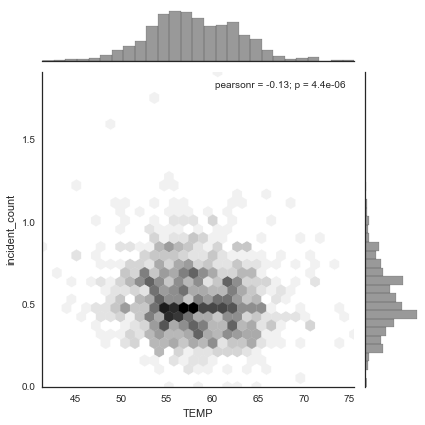

In [322]:

with sns.axes_style("white"):
    sns.jointplot(x="TEMP", y="incident_count", data=ndf, kind='hex', color='k');

In [323]:
# TODO : explore the extreme outliers, what are up with them?

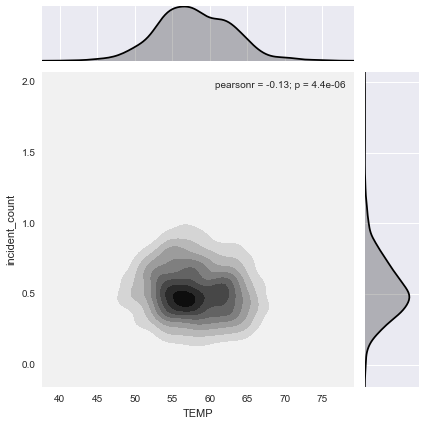

In [324]:
sns.jointplot(x="TEMP", y="incident_count", data=ndf, kind='kde', color='k');

In [325]:
df.head()

,dttm,incident_count,TEMP
0,2013-02-01,13,54.083333
1,2013-02-02,15,52.750000
2,2013-02-03,15,51.083333
3,2013-02-04,13,49.916667
4,2013-02-05,15,49.541667


In [326]:
df.describe()

,incident_count,TEMP
count,1235.000000,1193.000000
mean,12.750607,58.025158
std,4.586923,4.866921
min,1.000000,41.458333
25%,10.000000,54.625000
50%,12.000000,57.769231
75%,15.000000,61.500000
max,46.000000,75.500000


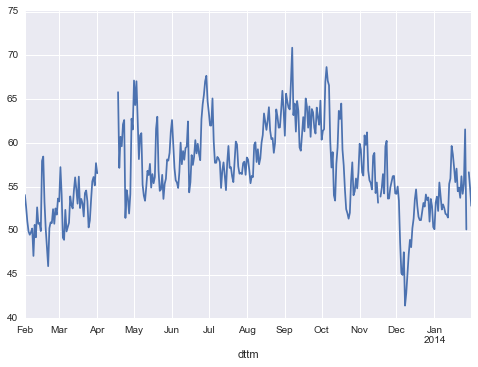

In [327]:
df[:365].set_index('dttm').TEMP.plot()

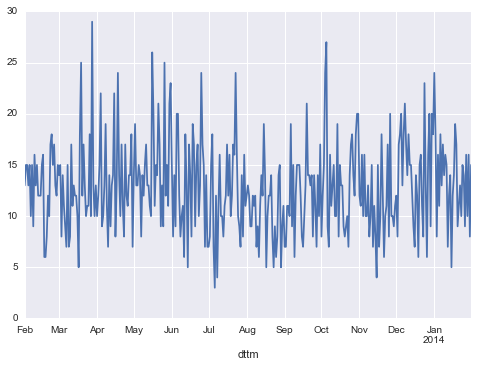

In [328]:
df[:365].set_index('dttm').incident_count.plot()

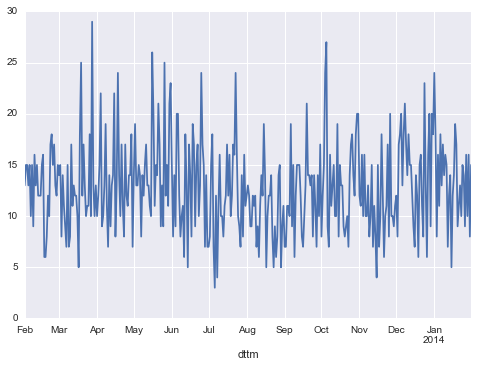

In [329]:
df[:365].set_index('dttm').incident_count.plot()

In [330]:
df.shape

(1235, 3)

In [331]:
df.incident_count.sum()

15747

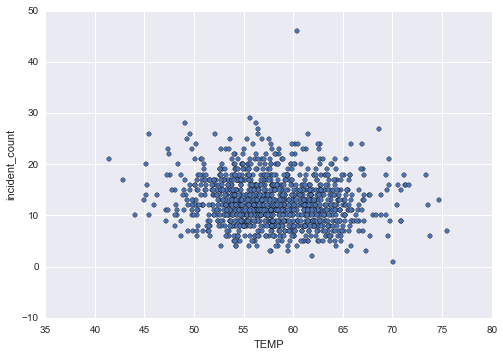

In [332]:
df.set_index('dttm').plot(kind='scatter', y='incident_count', x='TEMP')

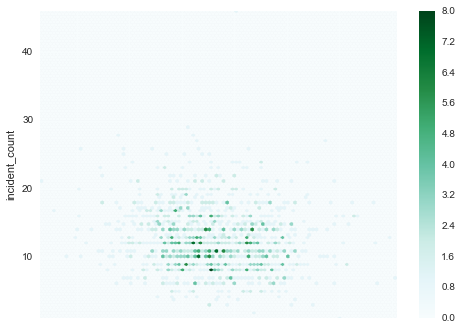

In [335]:
df.set_index('dttm').plot(kind='hexbin', y='incident_count', x='TEMP')

In [334]:
# nothing is jumping out here, but check the pearsonr and 
# TODO: rolling mean and rolling std

### Conclusions so far

In aggregate when looking at daily averages, and also when looking at hourly data, there is no strnog evidence that would suggest that we can reject the null hypothesis.

### TODO NEXT

Try and look at some other variables from NOAA to see if there are other correlations there. Make a master dataframe with all data by the hour from fdf and merge it with all numerical data from NOAA.

Do a proper cleaning and filling of NA values with averages and zeros, instead of just omitting them from the dataset.